# LSTM Traning (ZenML)

## Preparation

In [1]:
%cd stock-pred
%bookmark REPO_BASE_DIR

/mlsteam/lab/stock-pred


In [2]:
%pip install "zenml[server]"  # install ZenML
%pip install "matplotlib>=3.5.2"  # for plotting
!zenml integration install sklearn tensorflow tensorboard -y  # install ZenML integrations
!zenml init  # Initialize a ZenML repository
             # NOTE: zenml init will fail if any parent directory already has a ZenML repo

import IPython

# automatically restart kernel
IPython.Application.instance().kernel.do_shutdown(restart=True)

  Using cached MarkupSafe-1.1.1-cp38-cp38-manylinux2010_x86_64.whl (32 kB)
ERROR: werkzeug 2.2.2 has requirement MarkupSafe>=2.1.1, but you'll have markupsafe 1.1.1 which is incompatible.
ERROR: jinja2 3.1.2 has requirement MarkupSafe>=2.0, but you'll have markupsafe 1.1.1 which is incompatible.
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
⠙ Installing integrations.....
Initializing the ZenML global configuration version to 0.20.5
⠋ Initializing ZenML repository at /mlsteam/lab/stock-pred.
⠙ Initializing ZenML repository at /mlsteam/lab/stock-pred.
⠹ Initializing ZenML repository at /mlsteam/lab/stock-pred.
⠸ Initializing ZenML repository at /mlsteam/lab/stock-pred.
⠼ Initializing ZenML repository at /mlsteam/lab/stock-pred.
⠴ Initiali

{'status': 'ok', 'restart': True}

In [1]:
%cd -b REPO_BASE_DIR

# Forces to use CPU rather than GPU
# NVIDIA drivers of higher versions have messy implimentation of LSTM!
# Ref: https://github.com/mozilla/DeepSpeech/issues/3088#issuecomment-656056969
# Ref: https://github.com/tensorflow/tensorflow/issues/35950#issuecomment-577427083
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

(bookmark:REPO_BASE_DIR) -> /mlsteam/lab/stock-pred
/mlsteam/lab/stock-pred


## Define ML Pipelines

In [2]:
from zenml.steps import BaseParameters

class TrainerParams(BaseParameters):
    window: int = 50
    epochs: int = 15
    batch: int = 20
    test_ratio: float = .2

    data_path: str = 'data/20220808_tesla.csv'
    scaler_path: str = '/lab/trained/scaler.pkl'
    model_path: str = '/lab/trained/model'
    tensorboard_path: str = '/tensorboard'

In [3]:
from zenml.pipelines import pipeline

@pipeline
def train_lstm_pipeline(
    training_data_loader,
    plots_data_loader,
    model_trainer,
    model_validator,
    plotter
):
    scaler, train_size, x_train, y_train, x_test, y_test = training_data_loader()
    model = model_trainer(x_train, y_train)
    rmse, mape = model_validator(model, scaler, x_test, y_test)
    dates, y_actual = plots_data_loader()
    plotter(model, scaler, dates, train_size, y_actual, x_test)

## Implement Pipeline Steps

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from zenml.steps import Output, step

from train import (load_data_csv, transform_data, extract_x_y)

@step
def training_data_loader(config: TrainerParams) -> Output(
    scaler=StandardScaler, train_size=int,
    x_train=np.ndarray, y_train=np.ndarray,
    x_test=np.ndarray, y_test=np.ndarray
):
    _, stock_prices = load_data_csv(config.data_path)
    scaler, scaled_data = transform_data(stock_prices)

    train_size = int(len(scaled_data) * (1.0 - config.test_ratio))
    scaled_data_train = scaled_data[:train_size]
    x_train, y_train = extract_x_y(scaled_data_train, window=config.window, offset=config.window)
    x_test, y_test = extract_x_y(scaled_data, window=config.window, offset=train_size)
    
    return scaler, train_size, x_train, y_train, x_test, y_test

In [5]:
@step
def plots_data_loader(config: TrainerParams) -> Output(
    dates=np.ndarray, y_actual=np.ndarray
):
    dates, stock_prices = load_data_csv(config.data_path)
    return dates, stock_prices

In [6]:
from tensorflow.keras import Model

from train import (build_LSTM, train_model)

@step
def model_trainer(
    config: TrainerParams,
    x_train: np.ndarray, y_train: np.ndarray,
) -> Model:
    model = build_LSTM(x_train, units=config.window)
    train_model(model, x_train, y_train,
                config.epochs, config.batch,
                interactive_progress=True,
                tensorboard_path=config.tensorboard_path)
    return model

In [7]:
from train import (predict, get_rmse, get_mape)

@step
def model_validator(
    model: Model, scaler: StandardScaler,
    x_test: np.ndarray, y_test: np.ndarray
) -> Output(
    rmse=float, mape=float
):
    y_pred_scaled = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_test)
    
    rmse = get_rmse(pred=y_pred, actual=y_actual)
    mape = get_mape(pred=y_pred, actual=y_actual)
    print(f'✨RMSE: {rmse}, MAPE: {mape}')
    return rmse, mape

In [8]:
import matplotlib.pyplot as plt

@step
def plotter(
    model: Model, scaler: StandardScaler,
    dates: np.ndarray, train_size: int,
    y_actual: np.ndarray, x_test: np.ndarray
) -> None:
    y_test_pred_scaled = model.predict(x_test)
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
    
    fig = plt.figure(figsize=(20, 10))
    plt.plot(dates, y_actual, label='Actual Closing Price')
    plt.plot(dates[train_size:], y_test_pred, label='Pred Closing Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left')

## Run Pipeline

We are using ZenML's default stack (with default orchestrator and artifact store) here. So there is no need to setup stack.

Registered new pipeline with name train_lstm_pipeline.
Creating run train_lstm_pipeline-02_Nov_22-02_15_20_490194 for pipeline train_lstm_pipeline (Caching enabled)
Using stack default to run pipeline train_lstm_pipeline...
Step plots_data_loader has started.
Step plots_data_loader has finished in 0.702s.
Step training_data_loader has started.
Step training_data_loader has finished in 0.406s.
Step model_trainer has started.
Epoch 1/15
44/44 [==============================] - 5s 44ms/step - loss: 0.0701 - val_loss: 0.0123
Epoch 2/15
44/44 [==============================] - 1s 25ms/step - loss: 0.0061 - val_loss: 0.0220
Epoch 3/15
44/44 [==============================] - 1s 26ms/step - loss: 0.0053 - val_loss: 0.0118
Epoch 4/15
44/44 [==============================] - 1s 25ms/step - loss: 0.0051 - val_loss: 0.0176
Epoch 5/15
44/44 [==============================] - 1s 25ms/step - loss: 0.0041 - val_loss: 0.0097
Epoch 6/15
44/44 [==============================] - 1s 26ms/step - loss: 0.00

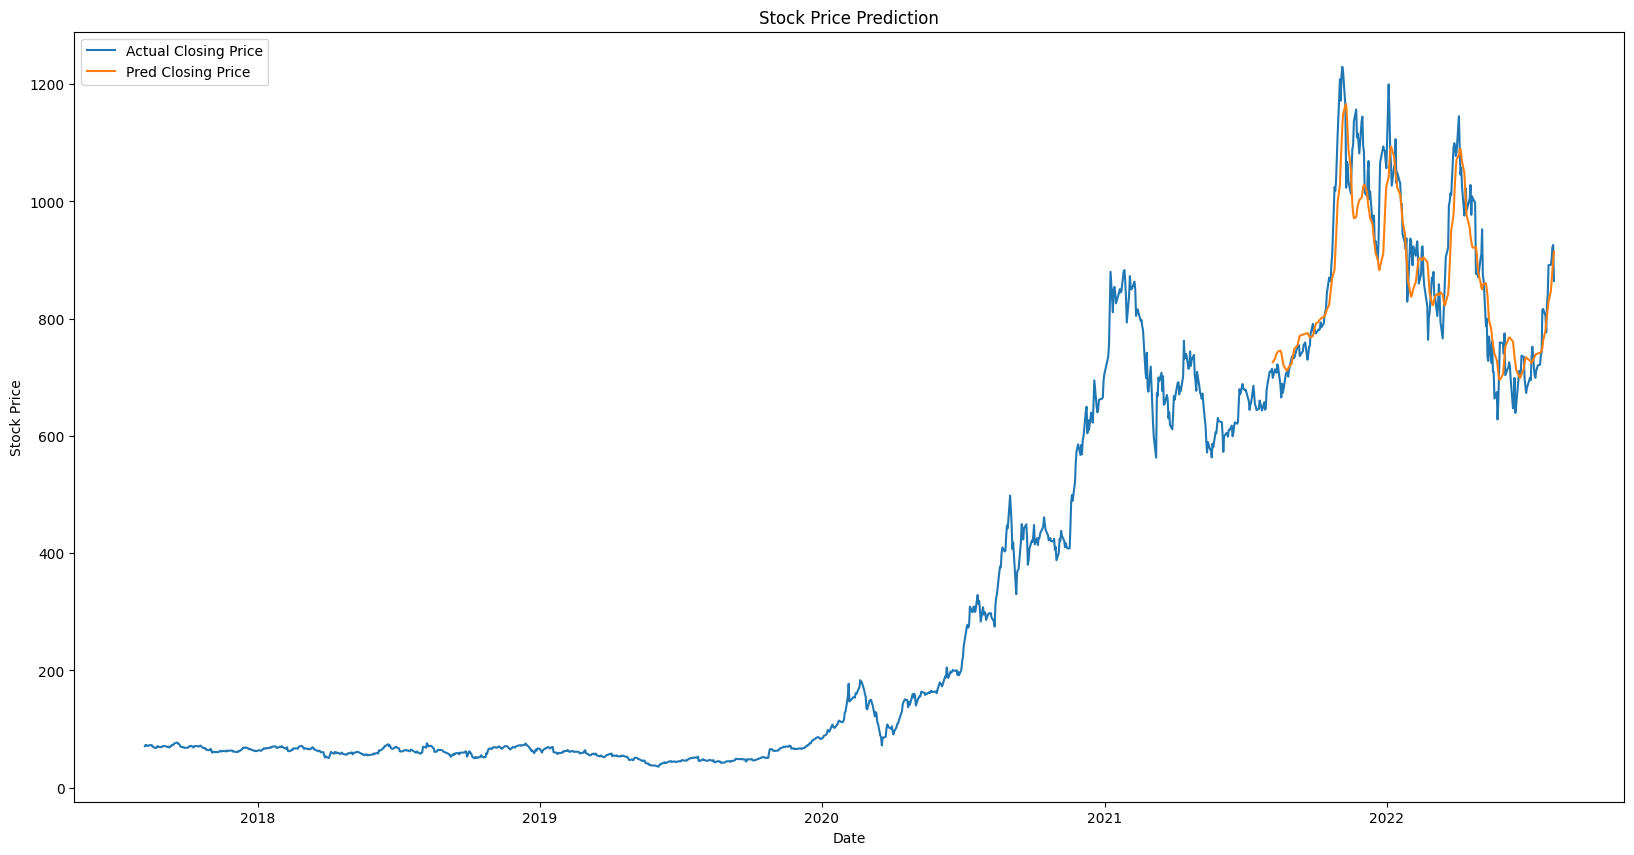

In [9]:
params = TrainerParams()
pipeline_instance = train_lstm_pipeline(
    training_data_loader(params),
    plots_data_loader(params),
    model_trainer(params),
    model_validator(),
    plotter()
)

pipeline_instance.run()

## Visualization

You could also view the pipeline graph and other information in *ZenML Dashboard*, which could be set up by:

```bash
zenml up --ip-address="0.0.0.0" --port=$PORT
```